In [44]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle
import random

In [2]:
## Load the map
#img_name = "Reduced Size Map.npy";
#field_map = Image.open(img_name);

file_name = "Reduced Size Map.npy";
#file_name = "Field Map.npy";
field_map = np.load(file_name);

'\nplt.hlines(0, 0, 6);\nplt.hlines(1, 0, 6);\nplt.hlines(2, 0, 6);\n\nplt.vlines(0, 0, 2.1);\nplt.vlines(1, 0, 2.1);\nplt.vlines(5, 0, 2.1);\n'

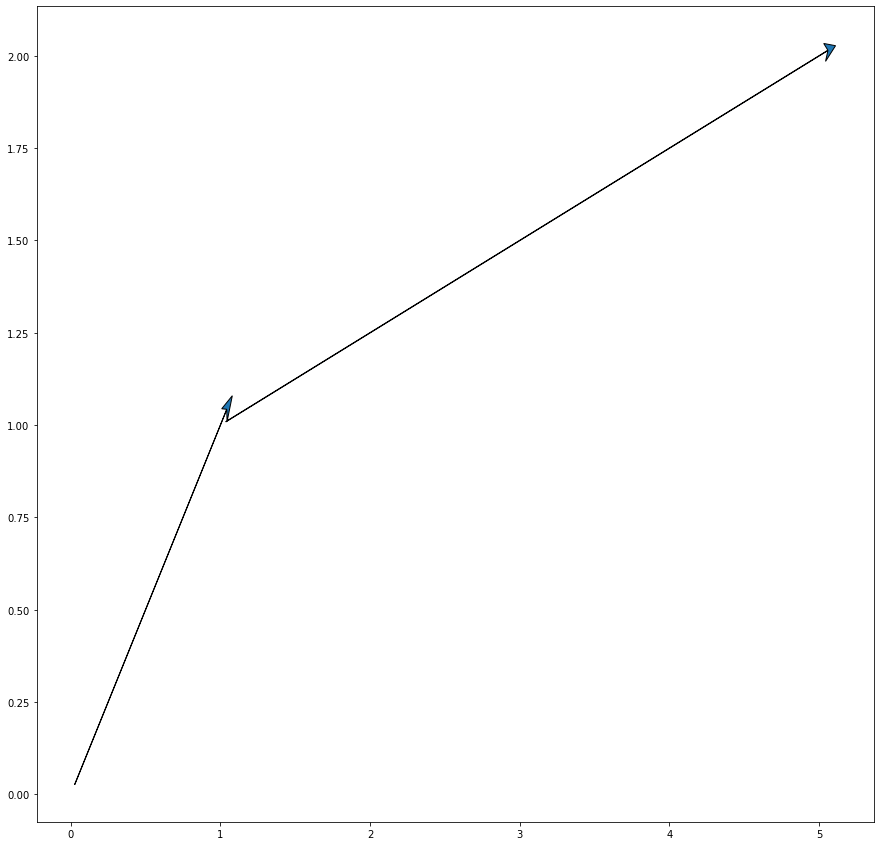

In [3]:
x_pos = [0, 1, 5];
y_pos = [0, 1, 2];
plt.figure(figsize=(15,15));
[plt.arrow(x_pos[i], y_pos[i], x_pos[i + 1] - x_pos[i], y_pos[i + 1] - y_pos[i], \
           head_width = 0.001*50, overhang = 0.3, head_starts_at_zero = True) for i in range(len(y_pos) - 1)];
"""
plt.hlines(0, 0, 6);
plt.hlines(1, 0, 6);
plt.hlines(2, 0, 6);

plt.vlines(0, 0, 2.1);
plt.vlines(1, 0, 2.1);
plt.vlines(5, 0, 2.1);
"""


In [4]:
## Load the sensor locations
with open('sensors.pkl', 'rb') as file:
    loc = pickle.load(file);
    loc = np.array(loc); # sensor locations are stored in loc
print(np.shape(loc));
print(loc);

(1269, 2)
[[150 150]
 [150 149]
 [141 140]
 ...
 [196  41]
 [ 30  86]
 [290 163]]


In [5]:
## Example for creating drone travel sequence

drone_coverage = [];
for i in range(4):
    drone_coverage.append([]);
print(drone_coverage);
drone_coverage[0].append(2);
drone_coverage[2].append(51);
drone_coverage[2].append(7);
print(drone_coverage);
x = [5];
x.append(4);
x.append(6);
x = x + [1, 2, 3]
print(x);

[[], [], [], []]
[[2], [], [51, 7], []]
[5, 4, 6, 1, 2, 3]


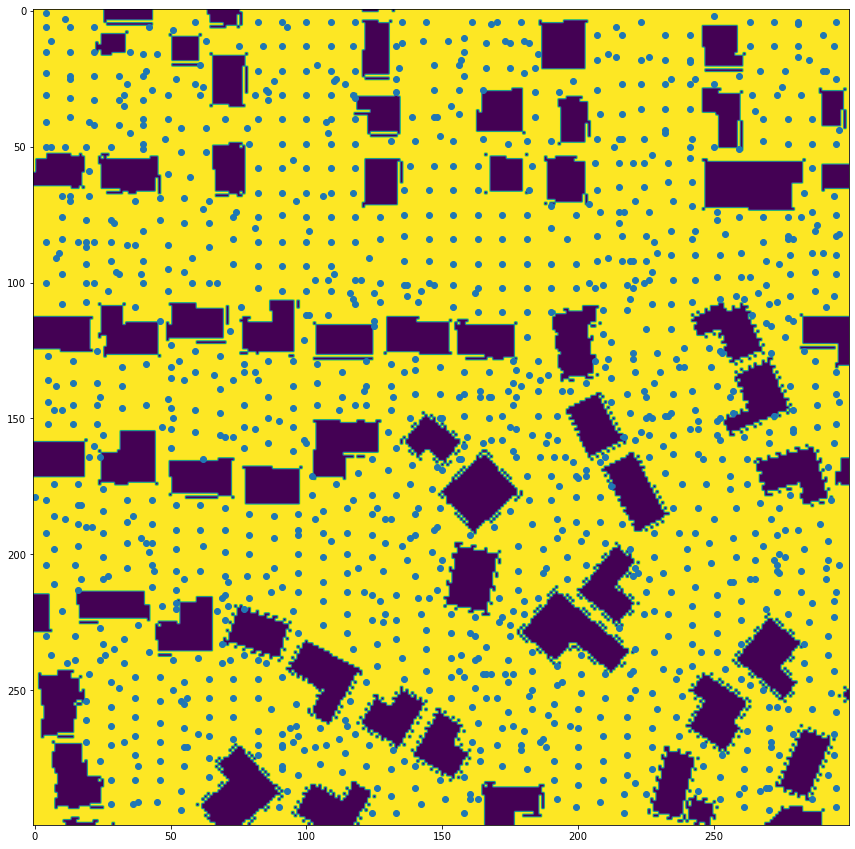

In [35]:
## Plotting sensor locations on map

plt.rcParams["figure.figsize"] = (15, 15);
implot = plt.imshow(field_map);
plt.rcParams["figure.figsize"] = (15, 15);
plt.scatter(loc[:, 1], loc[:, 0]);
plt.rcParams["figure.figsize"] = (15, 15);
plt.show();
plt.rcParams["figure.figsize"] = (15, 15);

In [7]:
# Test of sensor location definition
print(loc[0]);
print((150, 150));
print(len((150, 150)));
print(loc[0] == (150, 150));

[150 150]
(150, 150)
2
[ True  True]


In [129]:
## Helper Functions
#Inputs are two tuples, returns the distance between the two points
#If loc is inputted, first two inputs are taken to be indices in loc
def getDistance( input1, input2, loc = [] ):
    #If len is not passed in, we check if input1 and input2 are tuple points
    if (len(loc) == 0):
        #if no points passed
        if ((not np.shape(input1)) and (not np.shape(input2))):
            return -1;
        else:
            pt1 = input1;
            pt2 = input2;
            return ((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)**(0.5);
            
    #Otherwise assume input1 and input2 are indices in loc
    else:
        ind1 = input1;
        ind2 = input2;
        if (ind1 >= 0 and ind2 >= 0 and ind1 < len(loc) and ind2 < len(loc) and ind1 != ind2):
            pt1 = loc[ind1,:];
            pt2 = loc[ind2,:];
            return ((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)**(0.5);
        else:
            return -1;

#Function to add node to tree based for one parent
#If input2 is a node, then we add it right away. Otherwise we need to
#create the node first and then add it
#Parent is the index in tree of the parent node
#input 2 can either be a (1) node dictionary (don't use 3rd or 4th parameter)
#, (2) an integer representing an index in loc for the sensor location, or
#(3) a tuple representing the 2d location of the new node
def addNode(tree, input2, parent = -1, loc = []):
    #Check if second input is the node to add (dictionary type)
    if isinstance(input2, dict):
        node = input2;
    else:
        n_loc = input2;
        if (parent >= 0 and parent < len(tree)):
            dist_parent = getDistance(tree[parent]["loc"], n_loc, loc);
        else:
            dist_parent = -1;
            parent = -1;
        node = {"parent": parent, "children": [], "loc": n_loc, \
                    "dist_parent": dist_parent};
    tree.append(node)
    #Update children
    if (node["parent"] >= 0 and node["parent"] < len(tree) - 1):
        tree[tree[len(tree) - 1]["parent"]]["children"].append(len(tree) - 1);
    return tree;

#Pass through the indices of the spots that this drone travels, and the sensor locations
#returns total distance travelled by drone
def totalDistance(dronePath, loc = []):
    dist = 0;
    num_pts = len(dronePath);
    #If loc is not given, assume that the dronePath variable is a matrix
    #containing the sequence of all path points
    if (len(loc) == 0):
        for i in range(num_pts - 1):
            dist = dist + getDistance(dronePath[i], dronePath[i + 1]);
    else:
        for i in range(num_pts - 1):
            dist = dist + getDistance(dronePath[i], dronePath[i + 1], loc);
    return dist;

#Input is the min weight spanning tree, output is the preorder traversal list
#If no root location is given in the tree array, assume first node is root
def preorderTraversal(tree, root_index = 0):
    if (len(tree) == 0):
        return [];
    children = tree[root_index]["children"];
    num_children = len(children);
    traversal_cut = [tree[root_index]["loc"]];
    if num_children == 0:
        return traversal_cut;
    for i in range(num_children):
        traversal_cut = traversal_cut + preorderTraversal(tree, children[i]);
    return traversal_cut;

## Clustering
#Helper function to calculate objective function based on
#indicator variables r_nk and centers mu_ids
def getJ(r_nk, mu, loc):
    (N, K) = np.shape(r_nk);
    J = 0;
    for n in range(N):
        for k in range(K):
            J = J + (r_nk[n][k])*((getDistance(loc[n], mu[k]))**2);
    return J;
        
#K means Algorithm. Returns a tuple whose 
#first element is the centroids (mu), and
#second element is the centroid assignment matrix, size (len(loc) x K)
def KMeansClusters(K, loc):
    #Initialize centers using K++ means
    N = len(loc);
    mu = np.zeros((K, 2));
    mu[0,:] = loc[random.randint(0, N)];
    for i in range(1, K):
        #For each point, find how close it is to the closes centers
        distances = [float('inf')]*N;
        for j in range(N):
            #loop over existing centers
            for w in range(i):
                this_distance = getDistance(loc[j], mu[w]);
                if (this_distance < distances[j]):
                    distances[j] = this_distance;
        pt_to_add = np.argmax(distances);
        mu[i,:] = loc[pt_to_add];
    r_nk = -1;
    J = 0;
    J_next = -1;
    while (J_next != J):
        #Update J
        J = J_next;
        #Assign points to centers
        r_nk = np.zeros((N, K));
        for n in range(N):
            dist_to_mus = [0]*K;
            for k in range(K):
                dist_to_mus[k] = ((getDistance(loc[n], mu[k]))**2);
            mu_to_assign = np.argmin(dist_to_mus);
            r_nk[n][mu_to_assign] = 1;
        #Recalculate centers
        num_mu_groups = np.sum(r_nk, 0);
        for k in range(K):
            #Get points in center k
            i_n = 0;
            points_k = np.zeros((int(num_mu_groups[k]), 2));
            for n in range(N):
                if (r_nk[n][k] == 1):
                    points_k[i_n,:] = loc[n];
                    i_n = i_n + 1;
            #Average of points assigned to center k gives its new center
            if (i_n != num_mu_groups[k]):
                return -1;
            mu[k,:] = np.average(points_k, 0);
        #Recalculate new J
        J_next = getJ(r_nk, mu, loc);
    
    return (mu, r_nk);
    

In [137]:
## preorder test
blah1 = (0, 2);
blah2 = (4, 6);
total = [blah1];
total2 = [blah2]
total = total + total2
print(total);
print(total[0][1]);

num1 = 2;
num2 = 4;


[(0, 2), (4, 6)]
2


In [124]:
## Test of getDistance()
drn1 = loc[:3];
drn1_ind = [0, 1, 2];
print(drn1);
print(totalDistance(drn1));
print(totalDistance(drn1_ind, loc));

#Testing tuples
drn2 = [(150, 150), (150, 149), (141, 140)];
print(drn2);
print(totalDistance(drn2));

[[150 150]
 [150 149]
 [141 140]]
13.727922061357855
13.727922061357855
[(150, 150), (150, 149), (141, 140)]
13.727922061357855


(20, 2)
(1269, 20)


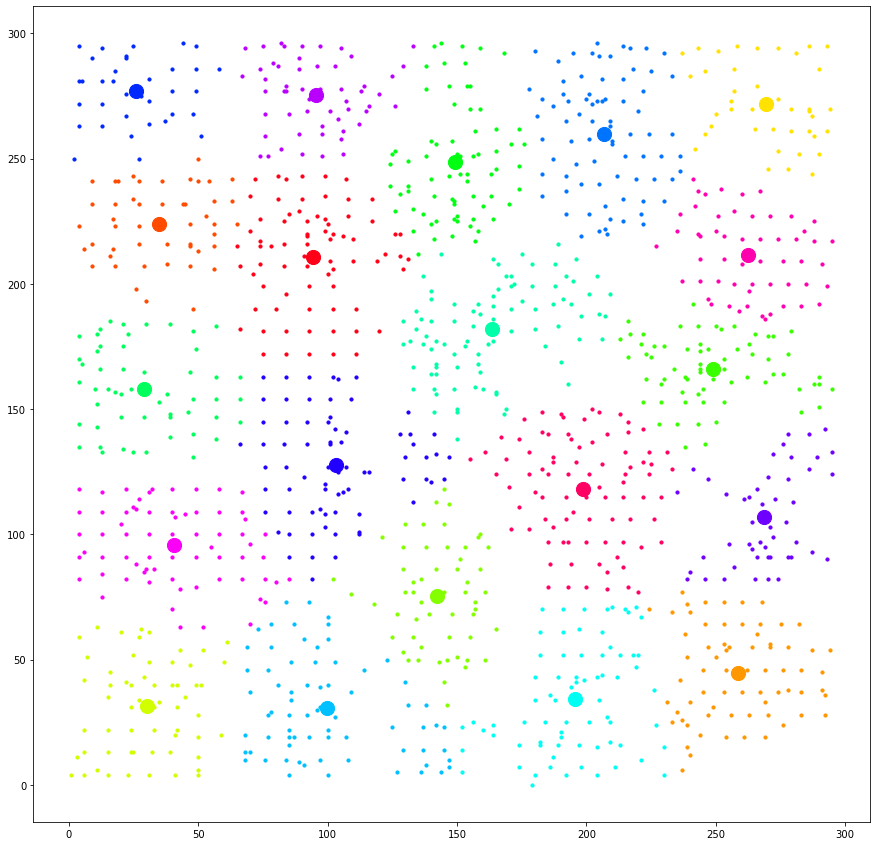

In [143]:
## Final testing for k means algorithm
N = len(loc);
K = 20;
(mu, r_nk) = KMeansClusters(K, loc);
print(np.shape(mu));
print(np.shape(r_nk));
#Generate k distinct colors
colors = plt.cm.get_cmap('hsv', K + 1);
num_groups = np.sum(r_nk, 0);
#Plot
for k in range(K):
    #plot center
    plt.scatter(mu[k][0], mu[k][1], s = 200, color = colors(k + 1));
    #plot data points
    i = 0;
    points_k = np.zeros((int(num_groups[k]), 2));
    for n in range(N):
        if (r_nk[n][k] == 1):
            points_k[i,:] = loc[n];
            i = i + 1;
    #Average of points assigned to center k gives its new center
    if (i != num_groups[k]):
        print("ERROR, i = ", i, " out of ", num_groups[k], " points in cluster ", k);
    plt.scatter(points_k[:,0], points_k[:,1], s = 10, color = colors(k + 1));
plt.show();


In [94]:
## Testing array indexing
ind = [1, 1, 0, 1, 0];
tf = [ind[i] == True for i in range(len(ind))];
pts = [1, 2, 3, 4, 5];
print(pts[ind == 1]);
xxx = [1.0, 2.0, 3.0];
print(xxx);
print(map(int,xxx));
xx = [3, 2];
print(np.shape(xx));

1
[1.0, 2.0, 3.0]
False


In [86]:
## Testing k means clustering preliminary
(mu_ids, r_nk) = KMeansClusters(3, loc);
print(mu_ids);
r_nk[2][0] = 1;
print(r_nk);
(n, k) = np.shape(r_nk);
print(n);
print(k);

print(r_nk[2][0]);
skree = r_nk[:, 0];
print(skree);
pt1 = np.zeros((5, 2));
pt1[0][0] = 1;
pt1[1][0] = 1;
pt1[3][0] = 1;
print(pt1);
print(np.average(pt1, 0));
pt2 = [1, 2, 3, 4, 5];
kek = [1, 1, 0, 1, 0];

TypeError: object of type 'int' has no len()

In [116]:
## Test of array initialization
m = [0]*3;
print(m);
[print(p) for p in range(1, 5)];
infs = [float('inf')]*3;
print(infs);
if (1000 < infs[0]):
    infs[0] = 1000;
print(infs);
[print(b) for b in range(1)];
aa = np.zeros((2, 2));
bb = np.zeros((2, 2));
cc = np.ones((2, 2));
print(aa == bb);
print(aa == cc);
keww = np.zeros((3, 500));
print(len(keww));
kekw = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]];
print(len(kekw));

[0, 0, 0]
1
2
3
4
[inf, inf, inf]
[1000, inf, inf]
0
[[ True  True]
 [ True  True]]
[[False False]
 [False False]]
3
3


In [16]:
## Example of creating distance graph - change conenctivity to distnace
nodes = [];
#Root node
center = 0
n_0 = {"parent": -1, "children": [], "loc": center, "dist_parent": -1};
nodes.append(n_0);
#Create new node
n_parent_loc = 0;
n_loc = 2;
n_i = {"parent": len(nodes) - 1, "children": [], "loc": n_loc, \
       "dist_parent": getDistance(n_parent_loc, n_loc, loc)};
nodes.append(n_i);
nodes[nodes[len(nodes) - 1]["parent"]]["children"].append(len(nodes) - 1);
#Test
print(nodes);
print(loc[nodes[1]["loc"]]);

[{'parent': -1, 'children': [1], 'loc': 0, 'dist_parent': -1}, {'parent': 0, 'children': [], 'loc': 2, 'dist_parent': 13.45362404707371}]
[141 140]


In [32]:
## Example of preorder traversal
graph = [];
graph = addNode(graph, "a", -1); #0
graph = addNode(graph, "b", 0); #1
graph = addNode(graph, "c", 1); #2
graph = addNode(graph, "e", 0); #3
graph = addNode(graph, "f", 3); #4
graph = addNode(graph, "g", 3); #5
graph = addNode(graph, "d", 1); #6
graph = addNode(graph, "w", 0); #7
graph = addNode(graph, "z", 7); #8
graph = addNode(graph, "x", 4); #9
graph = addNode(graph, "y", 4); #10
graph = addNode(graph, "o", 10); #11
graph_traversal = preorderTraversal(graph);
print(graph_traversal);

['a', 'b', 'c', 'd', 'e', 'f', 'x', 'y', 'o', 'g', 'w', 'z']


In [11]:
#Return list of points travelled to by big drone
def single_route(loc):
    # write a function that designs the route of the big drone in scenario 1
    t = 0;
    
    return t;

#Return list of points travelled to by each drone (drone_coverage)
def routes(m, loc):
    # write a function that designs the paths for the m drones to minimize the tota deployment time
    # return the deployment time
    t = 0;
    
    return t;

def simplify_graph(loc):
    # optional: write a function to simplify the map graph by ignoring some paths
    return True;

# You can choose any data structure you think best to represent nodes, graphs, and any other data types.

In [12]:
## Main Function
M = [1, 3, 5, 8, 10];

In [13]:
# plot the number of drones vs total deployment time